In [19]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub(r"[^\w\s]", "", sentence)
    sentence = re.sub(" ", "", sentence) 
    sentence = re.sub("\\n", "", sentence) 
    return(sentence)

In [3]:
import jieba
from collections import Counter
def prepare_data(good_file, bad_file, is_filter = True):
    all_words = [] 
    pos_sentences = [] 
    neg_sentences = [] 
    with open(good_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    return(pos_sentences, neg_sentences, diction)

In [4]:
pos_sentences, neg_sentences, diction = prepare_data("./data/good-evaluate/good.txt", "./data/good-evaluate/bad.txt")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.423 seconds.
Prefix dict has been built successfully.


./data/good-evaluate/good.txt 包含 8089 行, 100245 个词.
./data/good-evaluate/bad.txt 包含 5076 行, 55473 个词.


In [5]:
print(pos_sentences[0])

['这', '应该', '是', '我', '在', '网上', '买', '裤子', '最', '喜欢', '的', '一条', '的', '太赞']


In [6]:
def word2index(word, dictionary):
    if word in dictionary:
        return dictionary[word][0]
    else:
        return -1

def index2word(index, dictionary):
    for k, v in dictionary.items():
        if v[0] == index:
            return k
    return None

print(word2index('我', diction))

3


In [7]:
def sentence2vec(sentence, diction):
    vector = np.zeros(len(diction))
    for word in sentence:
        if word in diction:
            vector[word2index(word, diction)] += 1
    return (1.0 * vector / len(sentence))
    

In [8]:
dataset = []
labels = []

sentences = []

for i in pos_sentences:
    dataset.append(sentence2vec(i, diction))
    labels.append(0)
    sentences.append(i)

for i in neg_sentences:
    dataset.append(sentence2vec(i, diction))
    labels.append(1)
    sentences.append(i)

shuffled_dataset_idx = np.random.permutation(len(dataset))

dataset = [dataset[i] for i in shuffled_dataset_idx]
labels = [labels[i] for i in shuffled_dataset_idx]
sentences = [sentences[i] for i in shuffled_dataset_idx]

In [9]:
test_size = int(len(dataset) // 10)

train_dataset = dataset[2 * test_size:]
train_label = labels[2 * test_size:]

test_dataset = dataset[:test_size]
test_label = labels[:test_size]

valid_dataset = dataset[test_size:2 * test_size]
valid_label = labels[test_size:2 * test_size]

In [10]:
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1)
)

In [11]:
def rightness(y_pred, y_true):
    pred = torch.max(y_pred.data, 1)[1]
    rights = pred.eq(y_true.data.view_as(pred)).sum()
    return rights, len(y_true)

In [12]:
cost = torch.nn.NLLLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

records = []

lossess = []

for epoch in range(10):
    for i, data in enumerate(zip(train_dataset,train_label)):
        x, y = data
        x = torch.tensor(x, requires_grad=True, dtype=torch.float32).view(1, -1)
        y = torch.tensor(np.array([y]), dtype=torch.long)

        optimizer.zero_grad()
        predict = model(x)

        loss = cost(predict, y)
        lossess.append(loss.data.numpy())

        loss.backward()
        optimizer.step()

        if i % 3000 == 0:
            val_loss = []
            rights = []

            for j, val_data in enumerate(zip(valid_dataset, valid_label)):
                x, y = val_data
                x = torch.tensor(x, requires_grad=True, dtype=torch.float32).view(1, -1)
                y = torch.tensor(np.array([y]), dtype=torch.long)

                predict = model(x)

                right = rightness(predict, y)
                rights.append(right)

                loss = cost(predict, y)
                val_loss.append(loss.data.numpy())
            
            right_rate = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print("Epoch: {}, \tStep: {}, \tTrain Loss: {}, \tVal Loss: {}, \tVal Right Rate: {}".format(epoch, i, np.mean(lossess), np.mean(val_loss), right_rate))
            records.append([np.mean(lossess), np.mean(val_loss), right_rate])




Epoch: 0, 	Step: 0, 	Train Loss: 0.7285910844802856, 	Val Loss: 0.6860136985778809, 	Val Right Rate: 0.6285495011511896
Epoch: 0, 	Step: 3000, 	Train Loss: 0.6678779721260071, 	Val Loss: 0.6428109407424927, 	Val Right Rate: 0.6285495011511896
Epoch: 0, 	Step: 6000, 	Train Loss: 0.6449459195137024, 	Val Loss: 0.5761153697967529, 	Val Right Rate: 0.6400613967766692
Epoch: 0, 	Step: 9000, 	Train Loss: 0.6028465032577515, 	Val Loss: 0.47726526856422424, 	Val Right Rate: 0.7697620874904068
Epoch: 1, 	Step: 0, 	Train Loss: 0.5830902457237244, 	Val Loss: 0.4518188536167145, 	Val Right Rate: 0.8365310821181888
Epoch: 1, 	Step: 3000, 	Train Loss: 0.5514059662818909, 	Val Loss: 0.406758576631546, 	Val Right Rate: 0.8603223330775134
Epoch: 1, 	Step: 6000, 	Train Loss: 0.5258535742759705, 	Val Loss: 0.40528956055641174, 	Val Right Rate: 0.841903300076746
Epoch: 1, 	Step: 9000, 	Train Loss: 0.5008425116539001, 	Val Loss: 0.386873334646225, 	Val Right Rate: 0.8564850345356869
Epoch: 2, 	Step: 0, 	Tr

In [20]:
vals = []
test_records = []
for data, target in zip(test_dataset, test_label):
    x = torch.tensor(data, requires_grad=True, dtype=torch.float32).view(1, -1)
    y = torch.tensor(np.array([target]), dtype=torch.long)

    predict = model(x)
    val = rightness(predict, y)
    vals.append(val)
    
    rigths = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
    right_rate = 1.0 * rigths[0].data.numpy() / rigths[1]
    test_records.append(right_rate)
    print(right_rate)

1.0
1.0
1.0
0.75
0.8
0.8333333333333334
0.8571428571428571
0.875
0.8888888888888888
0.9
0.8181818181818182
0.8333333333333334
0.8461538461538461
0.8571428571428571
0.8666666666666667
0.875
0.8823529411764706
0.8888888888888888
0.8947368421052632
0.9
0.9047619047619048
0.9090909090909091
0.8695652173913043
0.8333333333333334
0.84
0.8461538461538461
0.8518518518518519
0.8571428571428571
0.8620689655172413
0.8333333333333334
0.8387096774193549
0.84375
0.8181818181818182
0.8235294117647058
0.8285714285714286
0.8333333333333334
0.8378378378378378
0.8421052631578947
0.8461538461538461
0.85
0.8536585365853658
0.8571428571428571
0.8604651162790697
0.8636363636363636
0.8666666666666667
0.8695652173913043
0.851063829787234
0.8541666666666666
0.8571428571428571
0.86
0.8627450980392157
0.8653846153846154
0.8679245283018868
0.8518518518518519
0.8545454545454545
0.8571428571428571
0.8596491228070176
0.8620689655172413
0.864406779661017
0.8666666666666667
0.8524590163934426
0.8548387096774194
0.85714

0.8892921960072595
0.8894927536231884
0.8896925858951176
0.8898916967509025
0.8900900900900901
0.8902877697841727
0.8904847396768402
0.8906810035842294
0.8908765652951699
0.8892857142857142
0.8894830659536542
0.8896797153024911
0.8898756660746003
0.8882978723404256
0.8884955752212389
0.8886925795053003
0.8888888888888888
0.8890845070422535
0.8892794376098418
0.8894736842105263
0.8879159369527145
0.8881118881118881
0.8883071553228621
0.8867595818815331
0.8852173913043478
0.8854166666666666
0.8856152512998267
0.8858131487889274
0.8860103626943006
0.8862068965517241
0.8864027538726333
0.8865979381443299
0.8867924528301887
0.886986301369863
0.8871794871794871
0.8873720136518771
0.8875638841567292
0.8860544217687075
0.8862478777589134
0.8864406779661017
0.8866328257191202
0.8868243243243243
0.8870151770657673
0.8872053872053872
0.8873949579831932
0.8875838926174496
0.8877721943048577
0.8879598662207357
0.8881469115191987
0.8883333333333333
0.8885191347753744
0.8887043189368771
0.88888888888

In [15]:
model.named_parameters

<bound method Module.named_parameters of Sequential(
  (0): Linear(in_features=7124, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

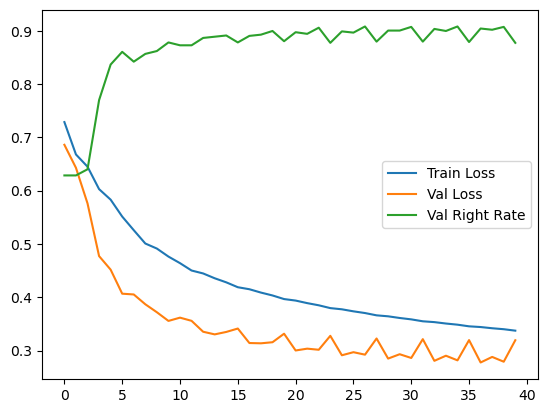

In [18]:
plt.plot(records)
plt.legend(['Train Loss', 'Val Loss', 'Val Right Rate'])
plt.show()

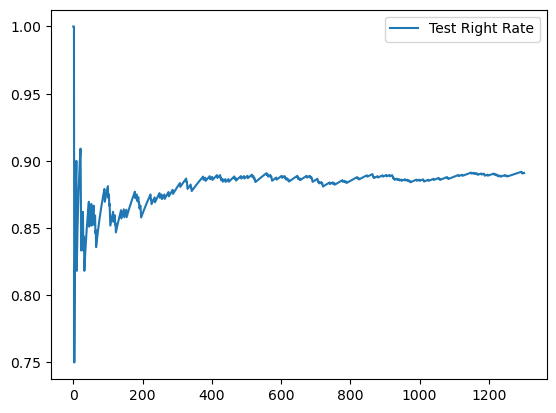

In [21]:
plt.plot(test_records)
plt.legend(['Test Right Rate'])
plt.show()

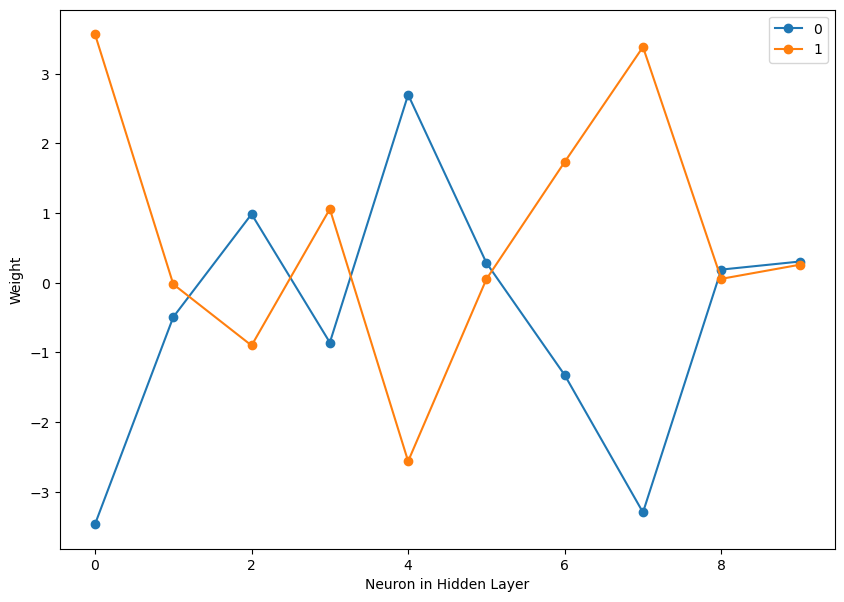

In [32]:
plt.figure(figsize=(10, 7))
for i in range(model[2].weight.size()[0]):
    if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label=i)
    else:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label=i)
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weight')
plt.legend()
plt.show()


        

In [45]:
sentence = "这个东西好垃圾，太垃圾了，垃圾的要死"
sentence = jieba.lcut(sentence)
vec = sentence2vec(sentence, diction)
x = torch.tensor(vec, requires_grad=True, dtype=torch.float32).view(1, -1)
predict = model(x)
predict = torch.max(predict.data, 1)[1].data.numpy()
print(predict)

[1]


In [48]:
for i in range(len(model[0].weight)):
    print("\n")
    print("Neuron: ", i)
    print("max:")
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
    for i in range(1, 20):
        print(index2word(st[-i][1], diction), end=" ")
    print("\nmin:")
    for i in range(1, 20):
        print(index2word(st[i][1], diction), end=" ")



Neuron:  0
max:
差 差评 不是 不怎么 差劲 很差 太慢 不值 不行 不 没有 裤子 太差 不怎么样 严重 太 不好 不要 不想 
min:
可以 好 喜欢 挺 合适 舒服 知道 哦 还行 宝贝 好评 很 挺不错 起来 好看 还 收到 快 老公 

Neuron:  1
max:
不怎么 差 差评 差劲 没有 很差 不 的 太 不怎么样 太慢 这 不值 起毛 不能 钱 哎 粗糙 太差 
min:
好 可以 很 挺 喜欢 哦 合适 知道 舒服 还好 还 好评 起来 宝贝 价格 物美价廉 大小 好看 行 

Neuron:  2
max:
下次 起来 合身 的 哦 挺 知道 买 很快 快 quot 好评 挺舒服 谢谢 舒适 价格 不过 比较 喜欢 
min:
不好 不是 差 不 差评 不怎么 慢 还 差劲 一般 太慢 很差 不行 不值 没有 太差 质量 上 严重 

Neuron:  3
max:
差 差评 不是 太慢 很差 差劲 还 不值 不行 衣服 没有 不 不怎么 严重 裤子 不怎么样 太差 不要 不想 
min:
好 喜欢 挺 合适 舒服 知道 哦 好评 起来 宝贝 很 好看 挺不错 可以 便宜 快 合身 就是 上 

Neuron:  4
max:
下次 起来 合身 知道 哦 的 买 挺 快 好评 很快 quot 舒适 挺舒服 价格 不过 谢谢 喜欢 收到 
min:
不好 不是 差 不 差评 不怎么 慢 还 差劲 太慢 一般 不值 很差 不行 没有 质量 上 太差 严重 

Neuron:  5
max:
知道 哦 舒适 买 挺 价格 挺不错 比较 物美价廉 物有所值 很快 柔软 非常 合身 了 不错 卖家 又 一下 
min:
不是 差评 不怎么 还 差 不 差劲 一般 不值 不好 裤子 不行 钱 码 质量 颜色 地摊货 不到 坑 

Neuron:  6
max:
差 差评 不是 不怎么 差劲 很差 太慢 不行 不值 没有 不 裤子 不怎么样 不好 太 严重 太差 不要 不想 
min:
好 可以 喜欢 挺 合适 舒服 知道 哦 还行 宝贝 很 好评 好看 起来 挺不错 快 老公 合身 收到 

Neuron:  7
max:
差 差评 不怎么 不是 很差 差劲 太慢 不值 不行 没有 不 裤子 严重 不怎么样 太差 太 不好 不要 